## PS2-6 Spam classification

#### (a)

In [1]:
import collections

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import src.svm as svm
import src.util as util

In [2]:
def get_words(message):
    """Get the normalized list of words from a message string.

    This function should split a message into words, normalize them, and return
    the resulting list. For splitting, you should split on spaces. For normalization,
    you should convert everything to lowercase.

    Args:
        message: A string containing an SMS message

    Returns:
       The list of normalized words from the message.
    """

    # *** START CODE HERE ***
    message = message.lower()
    return message.split(" ") 
    # *** END CODE HERE ***

In [3]:
def create_dictionary(messages):
    """Create a dictionary mapping words to integer indices.

    This function should create a dictionary of word to indices using the provided
    training messages. Use get_words to process each message. 

    Rare words are often not useful for modeling. Please only add words to the dictionary
    if they occur in at least five messages.

    Args:
        messages: A list of strings containing SMS messages

    Returns:
        A python dict mapping words to integers.
    """

    # *** START CODE HERE ***
    word_counts = collections.defaultdict(int)

    for message in messages:
        words = get_words(message)
        for word in words:
            word_counts[word] += 1
    resulting_dict = {}
    ind = 0
    for word, count in word_counts.items():
        if count >= 5:
            resulting_dict[word] = ind
            ind+=1
    return resulting_dict
    # *** END CODE HERE ***

In [4]:
def transform_text(messages, word_dictionary):
    """Transform a list of text messages into a numpy array for further processing.

    This function should create a numpy array that contains the number of times each word
    appears in each message. Each row in the resulting array should correspond to each 
    message and each column should correspond to a word.

    Use the provided word dictionary to map words to column indices. Ignore words that 
    are not present in the dictionary. Use get_words to get the words for a message.

    Args:
        messages: A list of strings where each string is an SMS message.
        word_dictionary: A python dict mapping words to integers.

    Returns:
        A numpy array marking the words present in each message.
    """
    # *** START CODE HERE ***
    m = len(messages)
    n = len(word_dictionary)
    matrix = np.zeros((m, n))

    for i, message in enumerate(messages):
        words = get_words(message)
        for word in words:
            if word in word_dictionary:
                matrix[i, word_dictionary[word]] += 1
    return matrix
    # *** END CODE HERE ***

#### (b)

\begin{align*}
\ell (\phi_y, \phi_{k \vert y = 1}, \phi_{k \vert y = 0})
    & = \sum_{i = 1}^{m} \log p(x^{(i)}, y^{(i)}; \ \phi_y, \phi_{k \vert y = 1}, \phi_{k \vert y = 0}) \\
    & = \sum_{i = 1}^{m} \log p(x^{(i)} \ \vert \ y^{(i)}; \ \phi_{k \vert y = 1}, \phi_{k \vert y = 0}) \ p(y^{(i)}; \ \phi_y) \\
\end{align*}

where $x^{(i)} \ \vert \ y^{(i) = 1}; \phi_{k \vert y = 1} \sim \mathrm{Mult}(n, \phi_{k \vert y = 1})$, $\phi_{k \vert y = 1}$ is the
probability that word $k$ appears given $y = 1$. Similar for $\phi_{k \vert y = 0}$.

Therefore, to maximize $\ell$ w.r.t $\phi_{k \vert y = 1}$ is equivalent to maximizing

$$
\sum_{i = 1}^{m} 1 \{ y^{(i)} = 1 \} \sum_{k = 1}^{n} x_k^{(i)} \log \phi_{k \vert y = 1}
$$

subject to the constraints $\phi_{k \vert y = 1} \geq 0$ and $\sum_{k = 1}^{n} \phi_{k \vert y = 1} = 1$, where $x_k^{(i)}$ is the
number of times that word $k$ appears in the $i$-th message.

By introducing a Lagrange multiplier $\lambda \in \mathbb{R}$ corresponding to the second constraint, we have

$$
\mathcal{L}(\lambda, \phi_{k \vert y = 1}) = \sum_{i = 1}^{m} 1 \{ y^{(i)} = 1 \} \sum_{i = 1}^{n} x_k^{(i)} \log \phi_{k \vert y = 1} - \lambda \big( \sum_{k = 1}^{n} \phi_{k \vert y = 1} - 1 \big)
$$

By solving the Lagrange multiplier problem and applying Laplace smoothing,

$$
\phi_{k \vert y = 1} := \frac{1 + \sum_{i = 1}^{m} 1 \{ y^{(i)} = 1 \} x_k^{(i)}}{n + \sum_{i = 1}^{m} 1 \{ y^{(i)} = 1 \} \sum_{j = 1}^{n} x_j^{(i)}}
$$.

Similarly,

$$
\phi_{k \vert y = 0} := \frac{1 + \sum_{i = 1}^{m} 1 \{ y^{(i)} = 0 \} x_k^{(i)}}{n + \sum_{i = 1}^{m} 1 \{ y^{(i)} = 0 \} \sum_{j = 1}^{n} x_j^{(i)}}
$$

and $\phi_y$ is still $(1 / m) \sum_{i = 1}^{m} 1 \{ y^{(i)} = 1 \}$.

In [5]:
def fit_naive_bayes_model(matrix, labels):
    """Fit a naive bayes model.

    This function should fit a Naive Bayes model given a training matrix and labels.

    The function should return the state of that model.

    Feel free to use whatever datatype you wish for the state of the model.

    Args:
        matrix: A numpy array containing word counts for the training data
        labels: The binary (0 or 1) labels for that training data

    Returns: The trained model
    """

    # *** START CODE HERE ***
    m, n = matrix.shape
    phi_y = np.mean(labels)
    phij_y1 = (1+matrix[labels==1].sum(axis=0))/(n+matrix[labels==1].sum())
    phij_y0 = (1+matrix[labels==0].sum(axis=0))/(n+matrix[labels==0].sum())
    return phi_y,phij_y1,phij_y0
    # *** END CODE HERE ***

To make a prediction, instead of computing the probabilities explicitly, we compare the logarithm of $p(y = 1 \ \vert \ x) / p(y = 0 \ \vert \ x)$ with 0.

\begin{align*}
\log \frac{p(y = 1 \ \vert \ x)}{p(y = 0 \ \vert \ x)}
    & = \log \frac{p(x \ \vert \ y = 1) \ p(y = 1)}{p(x \ \vert \ y = 0) \ p(y = 0)} \\
    & = \log \frac{\big( \prod_{k = 1}^{n} p(x_k \ \vert \ y = 1) \big) p(y = 1)}{\big( \prod_{k = 1}^{n} p(x_k \ \vert \ y = 0) \big) p(y = 0)} \\
    & = \sum_{k = 1}^{n} x_k (\log \phi_{k \vert y = 1} - \log \phi_{k \vert y = 0}) + \log \frac{\phi_y}{1 - \phi_y}
\end{align*}

In [6]:
def predict_from_naive_bayes_model(model, matrix):
    """Use a Naive Bayes model to compute predictions for a target matrix.

    This function should be able to predict on the models that fit_naive_bayes_model
    outputs.

    Args:
        model: A trained model from fit_naive_bayes_model
        matrix: A numpy array containing word counts

    Returns: A numpy array containg the predictions from the model
    """
    # *** START CODE HERE ***
    phi_y, phi_k_y1, phi_k_y0 = model

    return matrix @ (np.log(phi_k_y1) - np.log(phi_k_y0)) + np.log(phi_y / (1 - phi_y)) >= 0
    # *** END CODE HERE ***

In [7]:
train_messages, train_labels = util.load_spam_dataset(r'C:\Users\prakh\OneDrive - IIT Kanpur\Desktop\cs229-2018-autumn\problem-sets\PS2/data/ds6_train.tsv')
val_messages, val_labels = util.load_spam_dataset(r'C:\Users\prakh\OneDrive - IIT Kanpur\Desktop\cs229-2018-autumn\problem-sets\PS2/data/ds6_val.tsv')
test_messages, test_labels = util.load_spam_dataset(r'C:\Users\prakh\OneDrive - IIT Kanpur\Desktop\cs229-2018-autumn\problem-sets\PS2/data/ds6_test.tsv')
import os
import collections
dictionary = create_dictionary(train_messages)
os.makedirs("./output", exist_ok=True)
util.write_json('./output/p06_dictionary', dictionary)

train_matrix = transform_text(train_messages, dictionary)

np.savetxt('./output/p06_sample_train_matrix', train_matrix[:100,:])

val_matrix = transform_text(val_messages, dictionary)
test_matrix = transform_text(test_messages, dictionary)

naive_bayes_model = fit_naive_bayes_model(train_matrix, train_labels)
naive_bayes_predictions = predict_from_naive_bayes_model(naive_bayes_model, test_matrix)

np.savetxt('./output/p06_naive_bayes_predictions', naive_bayes_predictions)

naive_bayes_accuracy = np.mean(naive_bayes_predictions == test_labels)

print('Naive Bayes had an accuracy of {} on the testing set'.format(naive_bayes_accuracy))

Naive Bayes had an accuracy of 0.978494623655914 on the testing set


#### (c)

Recall the definition of $\phi_{k \vert y = 1}$ and $\phi_{k \vert y = 0}$,

$$\log \frac{p(x_j = i \ \vert \ y = 1)}{p(x_j = i \ \vert \ y = 0)} = \log \frac{\phi_{i \vert y = 1}}{\phi_{i \vert y = 0}}$$

In [8]:
def get_top_five_naive_bayes_words(model, dictionary):
    """Compute the top five words that are most indicative of the spam (i.e positive) class.

    Ues the metric given in 6c as a measure of how indicative a word is.
    Return the words in sorted form, with the most indicative word first.

    Args:
        model: The Naive Bayes model returned from fit_naive_bayes_model
        dictionary: A mapping of word to integer ids

    Returns: The top five most indicative words in sorted order with the most indicative first
    """

    _, phi_i_y1, phi_i_y0 = model

    inv_dictionary = { v: k for k, v in dictionary.items() }

    # Sort log(phi_i_y1 / phi_i_y0) in descending order and pick the top five
    top_five_indicative_word_index = np.argsort(-(np.log(phi_i_y1) - np.log(phi_i_y0)))[:5]

    return [inv_dictionary[i] for i in top_five_indicative_word_index]

In [9]:
top_5_words = get_top_five_naive_bayes_words(naive_bayes_model, dictionary)

print('The top 5 indicative words for Naive Bayes are: ', top_5_words)

The top 5 indicative words for Naive Bayes are:  ['claim', 'won', 'prize', 'tone', 'urgent!']


In [12]:
sns.set(style="whitegrid")
def plot_confusion_matrices(y_true, nb_pred, svm_pred):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Naive Bayes Confusion Matrix
    cm_nb = confusion_matrix(y_true, nb_pred)
    sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
    axes[0].set_title('Naive Bayes Confusion Matrix', fontsize=14)
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')
    axes[0].set_xticklabels(['Ham', 'Spam'])
    axes[0].set_yticklabels(['Ham', 'Spam'])

    # SVM Confusion Matrix
    cm_svm = confusion_matrix(y_true, svm_pred)
    sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens', ax=axes[1], cbar=False)
    axes[1].set_title('SVM (RBF) Confusion Matrix', fontsize=14)
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_ylabel('True Label')
    axes[1].set_xticklabels(['Ham', 'Spam'])
    axes[1].set_yticklabels(['Ham', 'Spam'])

    plt.tight_layout()
    plt.savefig('./output/confusion_matrices.png', dpi=300)
    plt.show()

In [13]:
def plot_top_spam_words(model, dictionary):

    _, phi_k_y1, phi_k_y0 = model
    
    spam_score = np.log(phi_k_y1) - np.log(phi_k_y0)
    
    top_indices = np.argsort(-spam_score)[:10]
    inv_dictionary = {v: k for k, v in dictionary.items()}
    
    top_words = [inv_dictionary[i] for i in top_indices]
    top_scores = [spam_score[i] for i in top_indices]
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_scores, y=top_words, palette='magma')
    plt.title('Top 10 Words Indicative of SPAM', fontsize=15)
    plt.xlabel('Log-Odds Ratio (Spam vs Ham)', fontsize=12)
    plt.savefig('./output/top_spam_words.png', dpi=300)
    plt.show()

Generating Confusion Matrices...


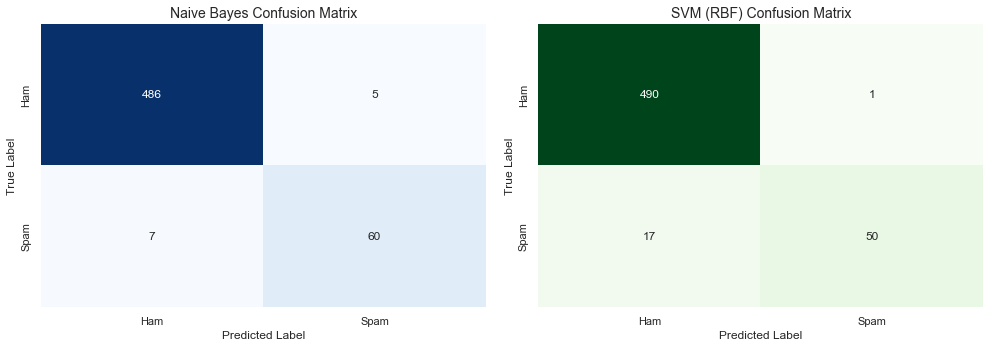

Generating Feature Importance Plot...


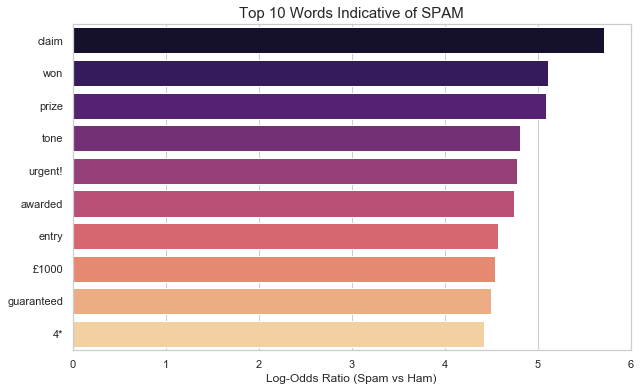

In [14]:
print("Generating Confusion Matrices...")
plot_confusion_matrices(test_labels, naive_bayes_predictions, svm_predictions)

print("Generating Feature Importance Plot...")
plot_top_spam_words(naive_bayes_model, dictionary)

#### (d)

In [10]:
def compute_best_svm_radius(train_matrix, train_labels, val_matrix, val_labels, radius_to_consider):
    """Compute the optimal SVM radius using the provided training and evaluation datasets.

    You should only consider radius values within the radius_to_consider list.
    You should use accuracy as a metric for comparing the different radius values.

    Args:
        train_matrix: The word counts for the training data
        train_labels: The spam or not spam labels for the training data
        val_matrix: The word counts for the validation data
        val_labels: The spam or not spam labels for the validation data
        radius_to_consider: The radius values to consider

    Returns:
        The best radius which maximizes SVM accuracy.
    """

    best_radius = radius_to_consider[0]
    best_accuracy = .0

    for radius in radius_to_consider:
        accuracy = np.mean(svm.train_and_predict_svm(train_matrix, train_labels, val_matrix, radius) == val_labels)
        if accuracy > best_accuracy:
            best_radius = radius
            best_accuracy = accuracy

    return best_radius

In [11]:
optimal_radius = compute_best_svm_radius(train_matrix, train_labels, val_matrix, val_labels, [0.01, 0.1, 1, 10])

# util.write_json('./output/p06_optimal_radius', optimal_radius)

print('The optimal SVM radius was {}'.format(optimal_radius))

svm_predictions = svm.train_and_predict_svm(train_matrix, train_labels, test_matrix, optimal_radius)

svm_accuracy = np.mean(svm_predictions == test_labels)

print('The SVM model had an accuracy of {} on the testing set'.format(svm_accuracy, optimal_radius))


The optimal SVM radius was 0.1
The SVM model had an accuracy of 0.967741935483871 on the testing set
